In [1]:
from random import randint
from tqdm import tqdm
from enum import IntEnum
import re
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from nltk import tokenize
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader

Скачиваем датасет, который будем использовать для вставки в текст слов паразитов

In [2]:
from datasets import load_dataset
dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/52400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

Dataset gazeta_dataset downloaded and prepared to /root/.cache/huggingface/datasets/IlyaGusev___gazeta_dataset/default/1.0.0/ef9349c3c0f3112ca4036520d76c4bc1b8a79d30bc29643c6cae5a094d44e457. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
len(dataset['train']['text'])

52400

In [4]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', padding=True)
model = BertModel.from_pretrained("bert-base-multilingual-cased")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# text = "два"
# encoded_input = tokenizer(text, return_tensors='pt', padding='max_length', max_length=512)
# output = model(**encoded_input)

In [6]:
# encoded_input

## Просмотр для слов токенов слов

In [118]:
# "типа" -> 21798
# "короче" -> 80062
cur_bad_word = "типа"
cur_bad_word_id = 21798
input_ids = tokenizer.encode(cur_bad_word)
input_ids

[101, 21798, 102]

In [119]:
# tensor(119) tensor(531)

In [120]:
output = tokenizer.decode(input_ids)
print(output)
output = tokenizer.decode([cur_bad_word_id])
output

[CLS] типа [SEP]


'типа'

### END токены слов

In [121]:
# !cd ../input/sent-with-bad-words && ls

In [122]:
# cnt = 0
# sents = {}
# bad_words = ['короче', 'типа', 'как бы', 'это самое', 'таки', 'вот', 'ну', 'значит']
# for bad_word in bad_words:
#     sents[bad_word] = []
    
# for sent in tqdm(dataset['train']['text']):
#     words_in_sent = re.split('\W+', sent)
#     for bad_word in bad_words:
#         if bad_word in words_in_sent:
#             cnt += 1
#             sents[bad_word].append(sent)

In [123]:
# for bad_word in bad_words:
#     print(bad_word, len(sents[bad_word]))

### Create list with sentences contain word 'короче' as significant part of sentence

In [124]:
native_using = []

### For word 'короче'

In [125]:
# def filter_sentence(text):
#     text = text.replace('\xa0', ' ')
#     text = text.replace('=', '')
#     text = text.replace('\xad', '')
#     return text

In [126]:
# native_using = []

In [127]:
if cur_bad_word == 'короче':
    native_using = []
    with open("../input/koroche/sents_with_bad_word_koroche.txt", 'r') as file:
        for line in file:
            line = line.strip()
            native_using.append(line)
#             native_using.append(filter_sentence(line))

In [128]:
native_using[0:10]

[]

### For word 'типа'

In [129]:
if cur_bad_word == 'типа':
    native_using = []
    with open("../input/small-tipa/sents_with_bad_word_tipa.txt", 'r') as file:
        for line in file:
            line = line.strip()
            native_using.append(line)

## End of word

In [130]:
len(native_using)

2318

In [131]:
clear_sents = []

In [132]:
for text in dataset['train']['text']:
    if len(clear_sents) > len(native_using):
        break
    sents = tokenize.sent_tokenize(text)
    clear_sents += sents

In [133]:
len(clear_sents)

2331

In [134]:
sents[0:10]

['Верховный суд Хакасии приговорил к пожизненному заключению за серию изнасилований и убийство четырех человек Дмитрия Лебедя — маньяка, заманивавшего в машину девушек под видом таксиста.',
 'Отбывать наказание мужчина будет в колонии особого режима.',
 'Судебный процесс начался 5 февраля и проходил за закрытыми дверями.',
 'Пока приговор не вступил в законную силу и может быть обжалован в Верховном суде России.',
 'Лебедь был задержан осенью 2018 года.',
 'По данным следствия, мужчина совершал преступления с 2013 по 2017 год в городе Абакан и прилегающих к нему районах.',
 'В частности, он совершил четыре убийства, а также покушения на убийство, ряд краж, изнасилований и насильственных действий сексуального характера.',
 'Согласно уголовному делу, которое содержит 22 тома, Лебедь нападал на женщин в возрасте от 18 до 34 лет.',
 '32-летний мужчина арендовал машину и, притворившись частным таксистом, предлагал одиноким женщинам, некоторые из которых были в алкогольном опьянении, подвезт

In [135]:
class ParasiteWordsClfHead(nn.Module):
    def __init__(self, in_size, out_size):
        super(ParasiteWordsClfHead, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_size, out_size),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


In [136]:
def insert_word(word: str, text: str) -> str:
    text_list = text.split(' ')
    pos = randint(0, len(text_list))
    
    if cur_bad_word == 'короче':
        if pos % 2 == 0:
            pos = 0
    
    end_of_sent = ''
    if pos == len(text_list) and pos > 0 and text_list[pos - 1][-1] in {'.', '!', '?'}:
        end_of_sent = text_list[pos - 1][-1]
        text_list[pos - 1] = text_list[pos - 1][0:-1]
#     if pos % 2 == 0:
#     word += ','
    if cur_bad_word == 'короче':
            
        if pos != len(text_list):
            word += ','
            
        if pos != 0 and text_list[pos - 1] != ',':
            text_list[pos - 1] += ','
    
    word += end_of_sent
    text_list.insert(pos, word)
    result_string = " ".join(text_list)
    return result_string

In [137]:
insert_word(cur_bad_word, 'да.')

'да типа.'

In [138]:
class TokenType(IntEnum):
    ORDINARY = 0
    PARASITE = 1
    SIMILAR_TO_PARASIT = 2
    EXTRA_PUNCT = 3

In [139]:
def calc_labels(true_ids: torch.tensor, 
                inp_ids: torch.tensor, 
                mask_ids: set = {23279, 20413}) -> np.array:
    
    '''
    This func return such list, as len(list) == len(inp_ids).
    And set 1 in such indexes where inp_ids[ind] => is not in true_ids, is in mask_ids
    '''
    punctuation_symbs = [',', ', ']
    set_punct_tokens = {117}
#     print(type(set_punct_tokens))
#     for symb in punctuation_symbs:
#         set_punct_tokens.update(set(tokenizer.encode(symb)[1:-1]))
    
    
    counter = 0
    indices_parasite_words = []
    indices_similar_words = []
    indices_extra_punct = []
#     print(true_ids)
#     print(inp_ids)
    for i, x in enumerate(inp_ids):
        if x == true_ids[i - counter] and int(x) in mask_ids:
            indices_similar_words.append(i)
        elif x == true_ids[i - counter]:
            continue
        elif int(x) in mask_ids:
            counter += 1
            indices_parasite_words.append(i)
        elif int(x) in set_punct_tokens:
            counter += 1
            indices_extra_punct.append(i)
        else:
#             print("DEBUG", i, counter, x, true_ids[i - counter], inp_ids[max(i - 10, 0):i + 10], true_ids[max(i - 10, 0):i + 10])
            print("DEBUG", i, counter, x, true_ids[i - counter], inp_ids, true_ids)
            print("DEBUG", true_ids.shape, inp_ids.shape)
            raise Exception("Bad token in calc_labels")
            
#     print(f"DEBUG: indices of bad_words: ", indices)
    
    labels = np.zeros(len(inp_ids), dtype=int)
    for ind in indices_parasite_words:
        labels[ind] = int(TokenType.PARASITE)
        
    for ind in indices_similar_words:
        labels[ind] = int(TokenType.SIMILAR_TO_PARASIT)
    
    for ind in indices_extra_punct:
        labels[ind] = int(TokenType.EXTRA_PUNCT)
        
    return labels

In [144]:
def test_single_sent(sentence: str):
#     token = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')
    bad_words = [cur_bad_word]
    print(bad_words)
    set_bad_words_tokens = set()
    for bad_word in bad_words:
        set_bad_words_tokens.update(set(tokenizer.encode(bad_word)[1:-1]))
    
    print("set_bad_words_tokens: ", set_bad_words_tokens)
        
    source_tokenized_sent = tokenizer.encode(sentence)
    inserted_sent = insert_word(cur_bad_word, sentence)
    
    insert_tokenized_sent = tokenizer.encode(inserted_sent)
#     print("TEST: source_tokenized_sent", source_tokenized_sent)
#     print("TEST: insert_tokenized_sent", insert_tokenized_sent)
    print("inserted_sent: ", inserted_sent)
    print("source sent: ", sentence)
    labels = calc_labels(source_tokenized_sent, insert_tokenized_sent, set_bad_words_tokens)
    print("TEST: labels", labels)
    print("TEST: tokens", insert_tokenized_sent)
    
    inds = np.where(np.logical_or(labels == TokenType.PARASITE, labels == TokenType.EXTRA_PUNCT))[0]
#     inds_extra_punct = np.where(labels == TokenType.EXTRA_PUNCT)[0]
    
    for ind in np.flip(inds):
        insert_tokenized_sent.pop(int(ind))
    
    
    
    assert(insert_tokenized_sent == source_tokenized_sent)
    

def test_calc_labels(sentenes: list):
    for sent in sentenes:
        test_single_sent(sent)
    return

In [145]:
test_single_sent("привет, короче, мир привет мир")

['типа']
set_bad_words_tokens:  {21798}
inserted_sent:  типа привет, короче, мир привет мир
source sent:  привет, короче, мир привет мир
TEST: labels [0 1 0 0 0 0 0 0 0 0 0 0 0]
TEST: tokens [101, 21798, 10913, 41102, 117, 80062, 67741, 117, 29345, 10913, 41102, 29345, 102]


In [146]:
ds_with_inserted_word = {
    'is_inserted': [],
    'with_natural': [],
    'clear': [],
    'inserted': [],
}

In [147]:
from copy import deepcopy
import random
import pandas as pd

In [148]:
random.seed(0)

In [149]:
# concated_sents = deepcopy(native_using)
# concated_sents.extend(clear_sents)
# random.shuffle(concated_sents)

Фильтруем от слишком длинных последовательностей

In [150]:
filtered_natural = filter(lambda val: tokenizer(val, truncation=True, return_tensors='pt', max_length=512)['input_ids'].shape[1] < 500, native_using)
filtered_natural = list(filtered_natural)

In [151]:
filtered_clear = filter(lambda val: tokenizer(val, truncation=True, return_tensors='pt', max_length=512)['input_ids'].shape[1] < 400, clear_sents)
filtered_clear = list(filtered_clear)

In [152]:
# filtered_concated_sents[0:10]

In [153]:
for sent in filtered_natural:
    rand_num = randint(1, 10)
    res = ""
    if rand_num <= 0:
        res = insert_word(cur_bad_word, sent)
        ds_with_inserted_word['is_inserted'].append(True)
    else:
        ds_with_inserted_word['is_inserted'].append(False)
        
    ds_with_inserted_word['clear'].append(sent)
    ds_with_inserted_word['inserted'].append(res)
    ds_with_inserted_word['with_natural'].append(True)

In [154]:
for sent in filtered_clear:
    rand_num = randint(1, 10)
    res = ""
    res = insert_word(cur_bad_word, sent)
    
    ds_with_inserted_word['is_inserted'].append(True)
    ds_with_inserted_word['clear'].append(sent)
    ds_with_inserted_word['inserted'].append(res)
    ds_with_inserted_word['with_natural'].append(False)

In [155]:
# for sent

In [156]:
df = pd.DataFrame(ds_with_inserted_word)

In [157]:
ds_with_inserted_word['clear'][0:10]

['Самоуправления делятся на староства, а они на сянюнайтии.Список уездов: Города Литвы В Литве выделяются 4 типа населённых пунктов: города, местечки, деревни и хутора.',
 '); на города и посёлки городского типа — 67,6 % лиц, здоровью которых причинён тяжкий вред (18,3 тыс.',
 'Возможно, что резкое сокращение численности мамонтов в условиях конкуренции за охотничьи ресурсы с людьми современного типа и послужило одной из причин вымирания неандертальцев.Первые люди 15—14 тыс.',
 'Полагая, что «чистых» экстравертов и интровертов не бывает, Юнг считал, что у каждого человека одна из этих установок преобладает.По мнению Юнга, одна из этих характеристик или «функций» "может быть" господствующей над другими, и тогда формируется соответствующий «психологический тип» — мыслительный, чувственный, ощущающий или интуитивный.Четыре психологических типа и две психологические установки Юнга дают восемь наглядных психологических типов (см.',
 'Для всех постюнговских типологий общей проблемой является 

In [158]:
train_df, test_df = train_test_split(df, test_size=0.3)
df.to_csv('df_koroche.csv', index=False)

train_df.to_csv('train_df_koroche.csv', index=False)
test_df.to_csv('test_df_koroche.csv', index=False)

df_loaded = pd.read_csv('df_koroche.csv')
df_loaded.head()

,is_inserted,with_natural,clear,inserted
0,False,True,"Самоуправления делятся на староства, а они на ...",NaN
1,False,True,"); на города и посёлки городского типа — 67,6 ...",NaN
2,False,True,"Возможно, что резкое сокращение численности ма...",NaN
3,False,True,"Полагая, что «чистых» экстравертов и интроверт...",NaN
4,False,True,Для всех постюнговских типологий общей проблем...,NaN


In [159]:
# filtered = filter(lambda val: tokenizer(val, truncation=True, return_tensors='pt', max_length=512)['input_ids'].shape[1] < 500, native_using)

In [160]:
rec = df_loaded.iloc[0]

In [161]:
rec['inserted']

nan

In [162]:
# filtered_list = list(filtered)

In [163]:
# len(filtered_list)

In [164]:
# tokenizer(p, truncation=True, return_tensors='pt', max_length=512)

In [165]:
# 101, 10913, 41102,   102

In [166]:
class TextDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
        """
        bad_words = [cur_bad_word]
        self.set_bad_words_tokens = set()
        total_sents = []
        for bad_word in bad_words:
            self.set_bad_words_tokens.update(set(tokenizer.encode(bad_word)[1:-1]))
            
        self.data_frame = pd.read_csv(csv_file)
        
#         self.sentences = []
        
#         for sent in native_sents:
#             self.sentences.append([1, sent.lower()]) # .replace(',', '')
            
#         for sent in clear_sents:
#             self.sentences.append([0, sent.lower()])
            
#         random.shuffle(self.sentences)
#         self.sentences = sentences
        

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        
        rec = self.data_frame.iloc[idx]
        clear = ''
        inserted = ''
        if rec['is_inserted']:
            clear = rec['clear']
            inserted = rec['inserted']
        else:
            clear = rec['clear']
            inserted = rec['clear']
            
        tokenized_src_data = tokenizer(clear, truncation=True, return_tensors='pt', padding='max_length', max_length=512)
        tokenized_ins_data = tokenizer(inserted, truncation=True, return_tensors='pt', padding='max_length', max_length=512)
        
        
        tokenized_src_sent = tokenized_src_data['input_ids'][0]
        tokenized_ins_sent = tokenized_ins_data['input_ids'][0]
        
        labels = calc_labels(tokenized_src_sent,
                             tokenized_ins_sent,
                             self.set_bad_words_tokens)
        
        return (tokenized_ins_data, labels)
        
#         if self.sentences[idx][0] == 1:
#             tokenized_src_data = tokenizer(self.sentences[idx][1], truncation=True, return_tensors='pt', padding='max_length', max_length=512)
#             labels = np.zeros(len(tokenized_src_data['input_ids'][0]), dtype=int)
#             print("Debug NATIVE", self.sentences[idx][1])
#             return (tokenized_src_data, labels)
        
        
        
#         self.sentences[idx] = self.sentences[idx][0:500]
#         inserted_sentence = self.sentences[idx][1]
        
#         for i in range(1):
#             inserted_sentence = insert_word(cur_bad_word, inserted_sentence)
        
#         print("Debug BAD", inserted_sentence)
#         tokenized_src_data = tokenizer(self.sentences[idx][1], truncation=True, return_tensors='pt', padding='max_length', max_length=512)
#         tokenized_ins_data = tokenizer(inserted_sentence, truncation=True, return_tensors='pt', padding='max_length', max_length=512)
# #         print(self.sentences[idx], inserted_sentence, sep='\n\n\n\n')
        
#         tokenized_src_sent = tokenized_src_data['input_ids'][0]
#         tokenized_ins_sent = tokenized_ins_data['input_ids'][0]
        
#         labels = calc_labels(tokenized_src_sent, 
#                              tokenized_ins_sent,
#                              self.set_bad_words_tokens)
        
# #         print(model(**tokenized_ins_data))
#         return (tokenized_ins_data, labels)

In [167]:
cur_bad_word

'типа'

In [168]:
len(clear_sents)

2331

In [169]:
# len(filtered_list)

In [170]:
# clear_sents

In [171]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [172]:
train_dataset = TextDataset('train_df_koroche.csv')
test_dataset = TextDataset('test_df_koroche.csv')

In [173]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [174]:
loss = torch.nn.L1Loss()
network = ParasiteWordsClfHead(768, 1)
optimizer = torch.optim.Adam(network.parameters(), lr=0.0001) 

In [175]:
for X, y in train_loader:
    for key, value in X.items():
        X[key] = torch.squeeze(X[key], 1)
#     model(**X)
    break


In [176]:
MAX_LENGHT = 512

In [177]:
def _epoch(network_bert, network_head, 
           loss, loader,
           optimizer=None,
           device = 'cpu',
           backward=True,
           ):
    losses = []
    accuracies = []
#     cnt = 1000
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        y_one_dim = y.view(y.shape[0] * y.shape[1])
#         print("y_one_dim.shape", y_one_dim.shape)
#         print("y.shape", y.shape)
        for key, value in X.items():
            X[key] = torch.squeeze(X[key], 1)
#         data = torch.squeeze(X[key], 1)
        indexes_with_bad_words = []
        for i in range(X['input_ids'].shape[0]):
#             print("set of ids: ", set(X['input_ids'][i].tolist()))
            if cur_bad_word_id in X['input_ids'][i].tolist():
                indexes_with_bad_words.append(X['input_ids'][i].tolist().index(cur_bad_word_id) + MAX_LENGHT * i)
        print("len indexes_with_bad_words:", len(indexes_with_bad_words))
        if len(indexes_with_bad_words) == 0:
            continue
        
        y = y.view(-1)
        with torch.no_grad():
            model_output = network_bert(**X)
#         print("model_output[0].shape: ", model_output[0].shape)
#         print("model_output[0][0]: ", model_output[0][0])
        word_embeddings = model_output[0].view(model_output[0].shape[0] * model_output[0].shape[1], -1)
        filtered_embeddings = torch.index_select(word_embeddings, 0, torch.tensor(indexes_with_bad_words).to(device))
        filtered_y = torch.index_select(y_one_dim, 0, torch.tensor(indexes_with_bad_words).to(device))
        filtered_y[filtered_y == 2] = 0
        filtered_y = filtered_y.float()
#         print("filtered_y: ", filtered_y)
#         print("filtered_embeddings.shape: ", filtered_embeddings.shape)
#         print("word_embeddings.shape: ", word_embeddings.shape)
        network_head.zero_grad()
        prediction = network_head(filtered_embeddings)
#         print("prediction.shape after head", prediction.shape)#.squeeze()
        prediction = prediction.squeeze()
#         print("prediction", prediction)#.squeeze()
#         prediction = (prediction>0.5).float()
#         print("prediction", prediction)
#         print("prediction.dtype", prediction.dtype)
#         print("filtered_y.dtype", filtered_y.dtype)
        loss_batch = loss(prediction, filtered_y)
#         print("loss_batch", loss_batch)
        val = loss_batch.cpu().item()
        losses.append(val)
#         print(losses)
#         print("val", val)
        
#         filtered_y = np.where(filtered_y == 2)
        print("filtered_y", filtered_y)
        
        print("prediction", prediction)
        if backward:
            print("backward!!!")
            loss_batch.backward()
            optimizer.step()
#         prediction = prediction.max(0)[1]
#         print("filtered_y", filtered_y)
#         accuracies.append((prediction==filtered_y).cpu().float().numpy().mean())
        prediction = (prediction>0.5).float()
        accuracies.append((prediction==filtered_y).cpu().float().numpy().mean())
#         accuracies.append(val)
#         cnt -= 1
        
#         if cnt < 0:
#             break
    return losses, accuracies

In [178]:
# _epoch(model, network, loss, train_loader, optimizer=optimizer)

In [179]:
model_output = ""

In [180]:
def train(network_bert, network_head, train_loader, test_loader,
          epochs, optimizer, loss, ravel_init=False,
          device='cpu', tolerate_keyboard_interrupt=True):
#     loss = nn.NLLLoss()
#     optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network_bert = network_bert.to(device)
    network_head = network_head.to(device)
    
    try:
        for epoch in range(epochs):
            network_head.train()
#             _epoch(model, network, loss, train_loader, optimizer=optimizer)
            losses, accuracies = _epoch(network_bert, 
                                        network_head,
                                        loss,
                                        train_loader,
                                        optimizer,
                                        device,
                                        True)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
#             network_head.eval()
#             losses, accuracies = _epoch(network_bert, 
#                                         network_head,
#                                         loss,
#                                         test_loader,
#                                         optimizer,
#                                         device,
#                                         False)

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('Epoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs


In [181]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [182]:
# device = 'cpu'

In [183]:
# network.parameters()

Epoch 4... (Train/Test) NLL: 0.161/0.161	Accuracy: 0.973/0.973


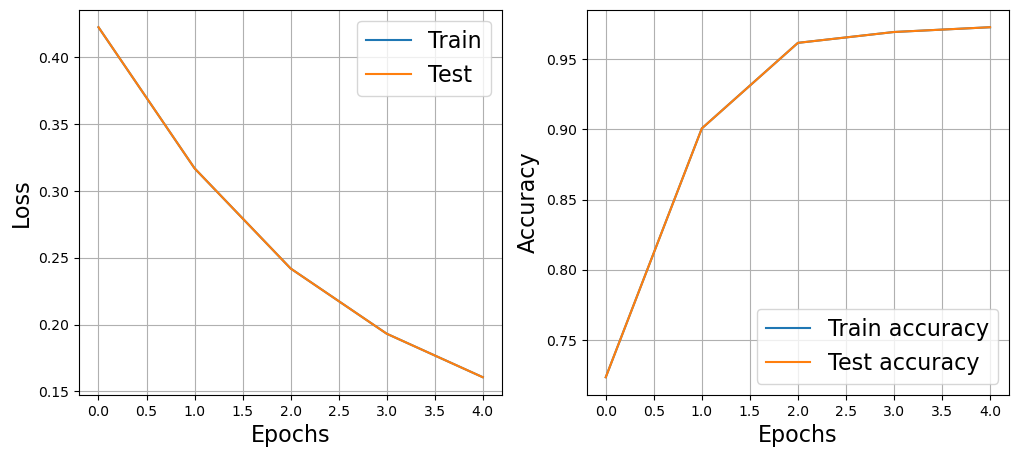

([0.42250486352656147,
  0.31691274747695075,
  0.2419366309843441,
  0.19312159842488788,
  0.1605591814559285],
 [0.42250486352656147,
  0.31691274747695075,
  0.2419366309843441,
  0.19312159842488788,
  0.1605591814559285],
 [0.7233911, 0.9006807, 0.9616337, 0.9693688, 0.9727723],
 [0.7233911, 0.9006807, 0.9616337, 0.9693688, 0.9727723])

In [184]:
train(model, network, train_loader, test_loader, 5, optimizer, loss, device=device)

In [59]:
# filtered_y tensor([0., 0., 0., 1.])
# # filtered_y tensor([1., 1., 1., 0.])

In [60]:
# for param in network.parameters():
#     print(param)

In [61]:
# old_param = []
# for param in network.parameters():
#     print(param)

In [62]:
# print(old_param)

In [63]:
# for name, param in network.named_parameters():
#     print(name, param)

In [185]:
from sklearn.metrics import f1_score

In [187]:
# f1_score(y_true, y_pred, average='macro')

In [188]:
import os

In [189]:
os.makedirs("models", exist_ok=True)

In [190]:
cur_bad_word

'типа'

In [191]:
# bad_word = "Короче, я вчера был на вечеринке у своих друзей, типа там было очень весело. Постараюсь рассказать как можно короче. Потом мы решили пойти в кино, типа на новый фильм. Было 2 типа фильма: ужастик и боевик. ужастик был короче, поэтому пошлм на него. Ну короче , фильм оказался не очень интересным, типа сюжет скучный. Если бы он был чуть короче, то было бы лучше. После кино мы пошли в кафе, типа перекусить. Короче, мы закусили и разговаривали до поздней ночи, типа было очень приятно провести время с друзьями."

In [192]:
if cur_bad_word == 'короче':
    PATH_TO_MODEL = 'models/short_classif.pt'
elif cur_bad_word == 'типа':
    PATH_TO_MODEL = 'models/tipa_classif.pt'
else:
    PATH_TO_MODEL = 'models/classif.pt'

PATH_TO_MODEL

'models/tipa_classif.pt'

In [193]:
network

ParasiteWordsClfHead(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [194]:
network.to('cpu')

ParasiteWordsClfHead(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [195]:
torch.save(network.state_dict(), PATH_TO_MODEL)

In [196]:
network = ParasiteWordsClfHead(768, 1)
network.load_state_dict(torch.load(PATH_TO_MODEL))
# network.eval()

<All keys matched successfully>

In [197]:
network

ParasiteWordsClfHead(
  (layers): Sequential(
    (0): Linear(in_features=768, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

## Inference model

In [198]:
from transformers import BertTokenizer, BertModel

In [199]:
# words_in_sent = re.split('\W+', sent)

In [200]:
import re
from time import process_time
import nltk
import logging
import string

In [301]:
class WordClassifier:
    def __init__(self, meta_info, device='cpu'):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', padding=True)
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.bert.eval()
        self.context_independent_bad_words = ['ну']

        self.clf_heads = {}
        for bad_word, meta_data in meta_info.items():
            clf_head = ParasiteWordsClfHead(768, 1)
            clf_head.load_state_dict(torch.load(meta_data["model_path"]))
            self.clf_heads[bad_word] = {}
            self.clf_heads[bad_word]['model'] = clf_head
            self.clf_heads[bad_word]['id'] = meta_data['parasite_word_id']

        self.logger = logging.getLogger(type(self).__name__)
        self.device = device
        self.to(device)
        self.logger.info(f'clf heads: {self.clf_heads}')
        

    def predict(self, text):
        self.logger.info(f"Input text: {text}")
        time_start = process_time()
        sents = nltk.tokenize.sent_tokenize(text)
        parasite_word_indexes = []
        words_count = 0

        for sentence in sents:
            sentence = sentence.lower()
            self.logger.info(f"Sentence: {sentence}")
            print("Sentence:", sentence)
            words_in_sent = nltk.word_tokenize(sentence)
            words_in_sent = [word for word in words_in_sent if word not in string.punctuation]

            self.logger.info(f"Splitted words: {words_in_sent} ")

            tokenized_sent = self.tokenizer(sentence, truncation=True, return_tensors='pt', padding='max_length',
                                            max_length=512)
            
            tokenized_sent.to(self.device)

            with torch.no_grad():
                word_embeddings = torch.tensor([])
                predictions = {}
                counters = {}
                bw_to_inds_with_parasite_ids = {}
                empty_sentence = True
                
                for bad_word, meta_data in self.clf_heads.items():
                    
                    bw_to_inds_with_parasite_ids[bad_word] = [
                        index for (index, item) in
                        enumerate(tokenized_sent['input_ids'][0].tolist()) if
                        item == meta_data['id']
                    ]
                    if len(bw_to_inds_with_parasite_ids[bad_word]) > 0:
                        empty_sentence = False
                        
                if not empty_sentence:
                    model_output = self.bert(**tokenized_sent)
                    word_embeddings = model_output[0].squeeze()
                    print(type(word_embeddings))
                    
                for bad_word, indexes_with_parasite_ids in bw_to_inds_with_parasite_ids.items():
                    model = self.clf_heads[bad_word]['model']
                    
                    if len(indexes_with_parasite_ids) == 0:
                        continue
                        
                    filtered_embeddings = torch.index_select(
                        word_embeddings, 0,
                        torch.tensor(indexes_with_parasite_ids).to(self.device)
                    )
                    
                    predictions[bad_word] = model(filtered_embeddings)

                    predictions[bad_word] = predictions[bad_word].squeeze(1)
                    predictions[bad_word] = (predictions[bad_word] > 0.5).float().tolist()

                    counters[bad_word] = -1

                for idx, word in enumerate(words_in_sent):
                    if word in counters.keys():
                        counters[word] += 1
                        if predictions[word][counters[word]] >= 0.9:
                            parasite_word_indexes.append(words_count + idx)

                    elif word in self.context_independent_bad_words:
                        parasite_word_indexes.append(words_count + idx)

            words_count += len(words_in_sent)

        time_end = process_time()
        self.logger.info(f"Parasite words indexes: {parasite_word_indexes}")
        self.logger.info(f'Time of processing: {time_end - time_start} seconds')
        return parasite_word_indexes
    
    def to(self, device: str):
        self.device = device
        self.bert.to(device)
        for bad_word in self.clf_heads:
            self.clf_heads[bad_word]['model'].to(device)
        self.logger.info(f'Model set to {device}')

In [302]:
# закоментировать, если нет модели!
model_paths = {
    "короче": {
        "model_path": 'models/short_classif.pt',
        "parasite_word_id": 80062,
    },
    "типа": {
        "model_path": 'models/tipa_classif.pt',
        "parasite_word_id": 21798,
    }
}

In [303]:
test_cases_koroche = {
    "У нас получились довольно неплохие результаты": [],
    "Ну короче, у нас получились довольно неплохие результаты": [0, 1],
    "Короче, у нас получилось, что первый короче, чем второй": [0],
#     "короче говоря ну получилось не очень": [0, 2],
#     "ну там короче, было много денег": [0, 2],
    "Первый провод короче второго.": [],
    "Перерыв короче матча.": [],
    "Короче, я не знаю, что с этим делать.": [0],
    "Ну, короче, это было неприятно.": [0, 1],
    "Короче говоря, я не согласен с тобой.": [0],
    "Я был на вечеринке, короче, там было весело.": [4],
    "Я не знаю, короче, как это работает.": [3],
    "Короче, это все, что я могу сказать на эту тему.": [0],
}

In [304]:
test_cases_tipa = {
    "Ну у нас типа неплохо получилось": [0, 3],
    "он полупроводникового типа": [],
    "они довольно умные типа": [3],
    "формат бинарного типа": [],
    "Ну типа": [0, 1],
    "Типа я шел и думал": [0]
}

In [305]:
test_cases_common = {
    "ну он короче шел по улице и типа понял что правая рука короче левой": [0, 2, 7],
    "карандаши квадратного типа короче круглого типа": [],
}

In [306]:
short_clf = WordClassifier(model_paths, 'cuda')

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [307]:
test_common_case = {
    "Короче, я вчера был на вечеринке у своих друзей, типа там было очень весело.": [0, 9],
    "Постараюсь рассказать как можно короче.": [],
    "Потом мы решили пойти в кино, типа на новый фильм.": [6],
    "Было два типа фильма, Ужастик и Боевик.": [],
    "Ужастик был короче, поэтому мы пошли на него.": [],
    "Ну, короче, фильм оказался не очень интересным, типа сюжет был скучный.": [0, 1, 7],
}

In [308]:
# words_in_sent = re.split('\W+', test_case)

In [309]:
long_sentence = 'В 1800-х годах, в те времена, когда не было еще ни железных, ни шоссейных дорог, ни газового, ни стеаринового света, ни пружинных низких диванов, ни мебели без лаку, ни разочарованных юношей со стеклышками, ни либеральных философов-женщин, ни милых дам-камелий, которых так много развелось в наше время, - в те наивные времена, когда из Москвы, выезжая в Петербург в повозке или карете, брали с собой целую кухню домашнего приготовления, ехали восемь суток по мягкой, пыльной или грязной дороге и верили в пожарские котлеты, в валдайские колокольчики и бублики, - когда в длинные осенние вечера нагорали сальные свечи, освещая семейные кружки из двадцати и тридцати человек, на балах в канделябры вставлялись восковые и спермацетовые свечи, когда мебель ставили симметрично, когда наши отцы были еще молоды не одним отсутствием морщин и седых волос, а стрелялись за женщин и из другого угла комнаты бросались поднимать нечаянно и не нечаянно уроненные платочки, наши матери носили коротенькие талии и огромные рукава и решали семейные дела выниманием билетиков, когда прелестные дамы-камелии прятались от дневного света, - в наивные времена масонских лож, мартинистов, тугендбунда, во времена Милорадовичей, Давыдовых, Пушкиных, - в губернском городе К. был съезд помещиков, и кончались дворянские выборы, короче. Ну и да'

In [310]:
for test_case, labels in test_cases_tipa.items():
    predicts = short_clf.predict(test_case)
    if predicts != labels:
        print('BAD RESULT!', "Test: ", test_case, "labels:", labels, "predict:", predicts)
#     assert(predicts == labels)

Sentence: ну у нас типа неплохо получилось
<class 'torch.Tensor'>
Sentence: он полупроводникового типа
<class 'torch.Tensor'>
Sentence: они довольно умные типа
<class 'torch.Tensor'>
Sentence: формат бинарного типа
<class 'torch.Tensor'>
Sentence: ну типа
<class 'torch.Tensor'>
Sentence: типа я шел и думал
<class 'torch.Tensor'>


In [ ]:
short_clf.predict(long_sentence)

In [250]:
# test1 = "Короче, типа, я был на вечеринке у своего друга. Там было много народу, типа, и все они были очень веселыми. Мы пили пиво, короче, и слушали музыку. Типа, было так много людей, что я даже не помню всех их имен. Короче, мы провели там всю ночь, типа, и ушли только утром. Это была очень крутая вечеринка, типа, и я надеюсь, что еще раз попаду на нее. Короче, это был один из лучших вечеров в моей жизни, типа."
# test2 = "Короче, я вчера был на вечеринке у своих друзей, типа там было очень весело. Постараюсь рассказать как можно короче. Потом мы решили пойти в кино, типа на новый фильм. Было два типа фильма, Ужастик и Боевик. Ужастик был короче, поэтому мы пошли на него. Ну короче, фильм оказался не очень интересным, типа сюжет был скучный."
# test3 = "При такой системе приняты уроки длиной 45 минут (бывают короче, но, как правило, не менее 35 минут)."

In [251]:
# pred = short_clf.predict(test2)

In [252]:
native_using[0]

'Самоуправления делятся на староства, а они на сянюнайтии.Список уездов: Города Литвы В Литве выделяются 4 типа населённых пунктов: города, местечки, деревни и хутора.'

In [253]:
for test_case, labels in test_cases_koroche.items():
    predicts = short_clf.predict(test_case)
    if predicts != labels:
        print('BAD RESULT!', "Test: ", test_case, "labels:", labels, "predict:", predicts)
#         print()
#     assert(predicts == labels)

BAD RESULT! Test:  Короче, у нас получилось, что первый короче, чем второй labels: [0] predict: [0, 6]
BAD RESULT! Test:  Перерыв короче матча. labels: [] predict: [1]


In [254]:
for test_case, labels in test_cases_common.items():
    predicts = short_clf.predict(test_case)
    if predicts != labels:
        print('BAD RESULT!', "Test: ", test_case, "labels:", labels, "predict:", predicts)

BAD RESULT! Test:  ну он короче шел по улице и типа понял что правая рука короче левой labels: [0, 2, 7] predict: [0, 7]


In [256]:
for test_case, labels in test_common_case.items():
    predicts = short_clf.predict(test_case)
    if predicts != labels:
        print('BAD RESULT!', "Test: ", test_case, "labels:", labels, "predict:", predicts)